<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.4 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=2e6593a63957de3ec36caa129c12569c4e3bc6520526c058aa7e5c57ce6aec70
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
pip install keras --upgrade

In [3]:
#Importing necessary libraries
import pandas as pd
import scikeras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
import os
from statsmodels.tsa.arima_model import ARIMA

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/LCL-June2015v2_134.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005555,Std,2012-06-15 03:30:00.0000000,0.118
1,MAC005555,Std,2012-06-15 04:00:00.0000000,0.078
2,MAC005555,Std,2012-06-15 04:30:00.0000000,0.091
3,MAC005555,Std,2012-06-15 05:00:00.0000000,0.068
4,MAC005555,Std,2012-06-15 05:30:00.0000000,0.092
5,MAC005555,Std,2012-06-15 06:00:00.0000000,0.194
6,MAC005555,Std,2012-06-15 06:30:00.0000000,0.091
7,MAC005555,Std,2012-06-15 07:00:00.0000000,0.069
8,MAC005555,Std,2012-06-15 07:30:00.0000000,0.088
9,MAC005555,Std,2012-06-15 08:00:00.0000000,0.087


In [6]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [7]:
#Looking for columns' datatypes
print(f"full_df columns datatypes: {full_df.dtypes} \n")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object 



In [76]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])


# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time


# Display the first few rows to verify
print(full_df.head())

KeyError: 'DateTime'

In [77]:
full_df.set_index('DateTime', inplace=True)

KeyError: "None of ['DateTime'] are in the columns"

In [78]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [79]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['Date', 'stdorToU', 'LCLid']).agg({'KWH/hh (per half hour) ': 'mean'}).reset_index()
full_df_daily.head(20)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [11]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['Date', 'stdorToU', 'LCLid', 'KWH/hh (per half hour) '] 

full_df_daily shape: (20876, 4) 

full_df_daily columns datatypes: Date                        object
stdorToU                    object
LCLid                       object
KWH/hh (per half hour)     float64
dtype: object 

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     5
dtype: int64 



In [80]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['KWH/hh (per half hour) '].isnull()].index
print(nan_indices)

Index([9038, 9039, 9040, 9041, 9044], dtype='int64')


In [81]:
#Dealing with nan values
full_df_daily['KWH/hh (per half hour) '].fillna(full_df_daily['KWH/hh (per half hour) '].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [14]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     0
dtype: int64 



In [15]:
##Descriptive Statistics
full_df_daily.describe()

,KWH/hh (per half hour)
count,20876.000000
mean,0.217520
std,0.139705
min,0.000000
25%,0.112432
50%,0.179531
75%,0.291630
max,1.391292


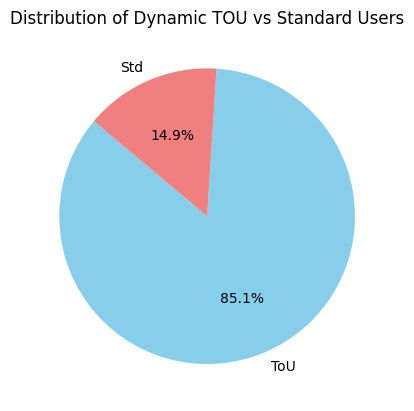

In [16]:
# Count the occurrences of each category
counts = full_df_daily['stdorToU'].value_counts()

# Plot a pie chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Dynamic TOU vs Standard Users')
plt.show()


            Date stdorToU      LCLid  KWH/hh (per half hour) 
3005  2012-04-24      Std  MAC005561                 0.208625
3028  2012-04-25      Std  MAC005561                 0.047000
3293  2012-05-07      Std  MAC005562                 0.192149
3316  2012-05-08      Std  MAC005562                 0.169229
3339  2012-05-09      Std  MAC005562                 0.137375
         Date stdorToU      LCLid  KWH/hh (per half hour) 
0  2011-11-23      ToU  MAC000146                 0.187300
1  2011-11-24      ToU  MAC000146                 0.178417
2  2011-11-25      ToU  MAC000146                 0.140479
3  2011-11-26      ToU  MAC000146                 0.125604
4  2011-11-27      ToU  MAC000146                 0.119583


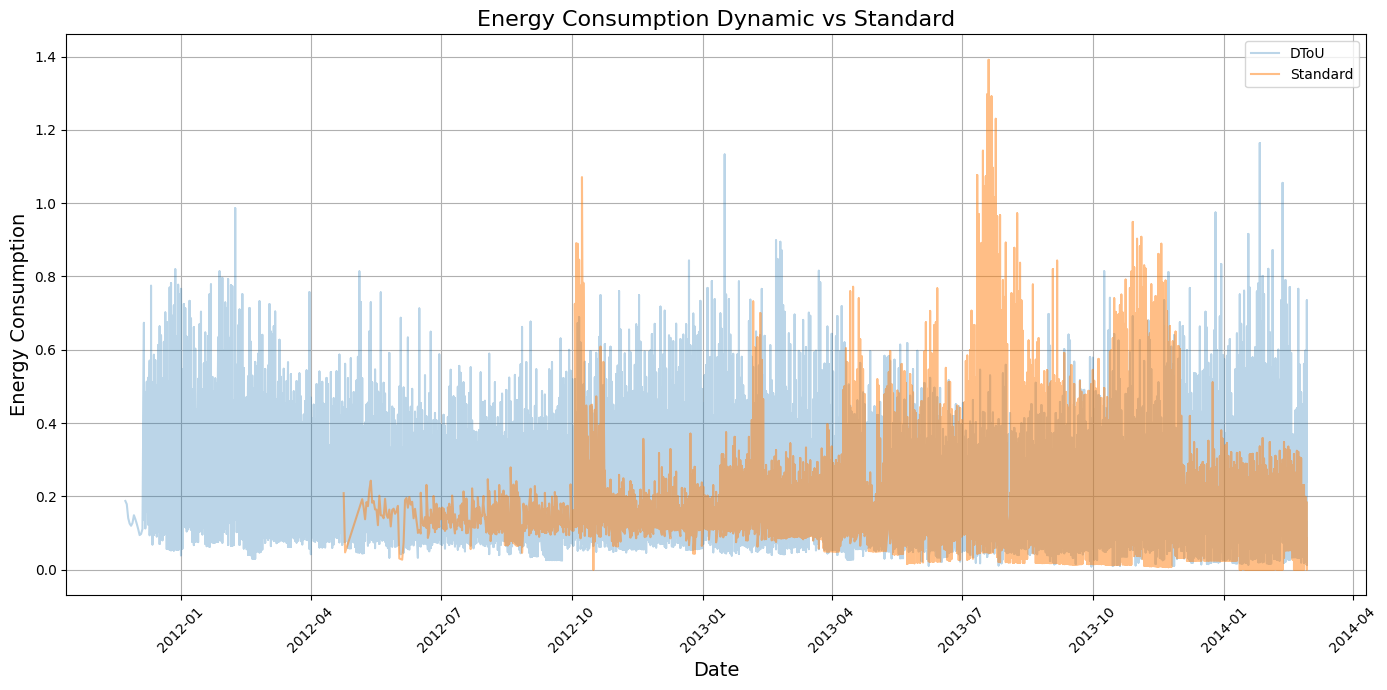

In [17]:
# Filter for dynamic and standard pricing
df_standard = full_df_daily[full_df_daily['stdorToU'] == 'Std']
df_dynamic = full_df_daily[full_df_daily['stdorToU'] == 'ToU']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
#plt.hist(df_dynamic['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'b', label='Dynamic')
#plt.hist(df_standard['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'r', label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['KWH/hh (per half hour) '], alpha = 0.3, label='DToU')
plt.plot(df_standard['Date'], df_standard['KWH/hh (per half hour) '],alpha = 0.5, label='Standard')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
# Check for NaNs in the input data for the standard users
if df_standard.isnull().values.any():
    print("NaN values found in the input data for standard users.")
else:
    print("No NaN values in the input data for standard users.")


No NaN values in the input data for standard users.


In [19]:
quantile1 = full_df_daily['KWH/hh (per half hour) '].quantile(0.25)
quantile3 = full_df_daily['KWH/hh (per half hour) '].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [20]:
full_df_daily['log_KWH'] = np.log(full_df_daily['KWH/hh (per half hour) '])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


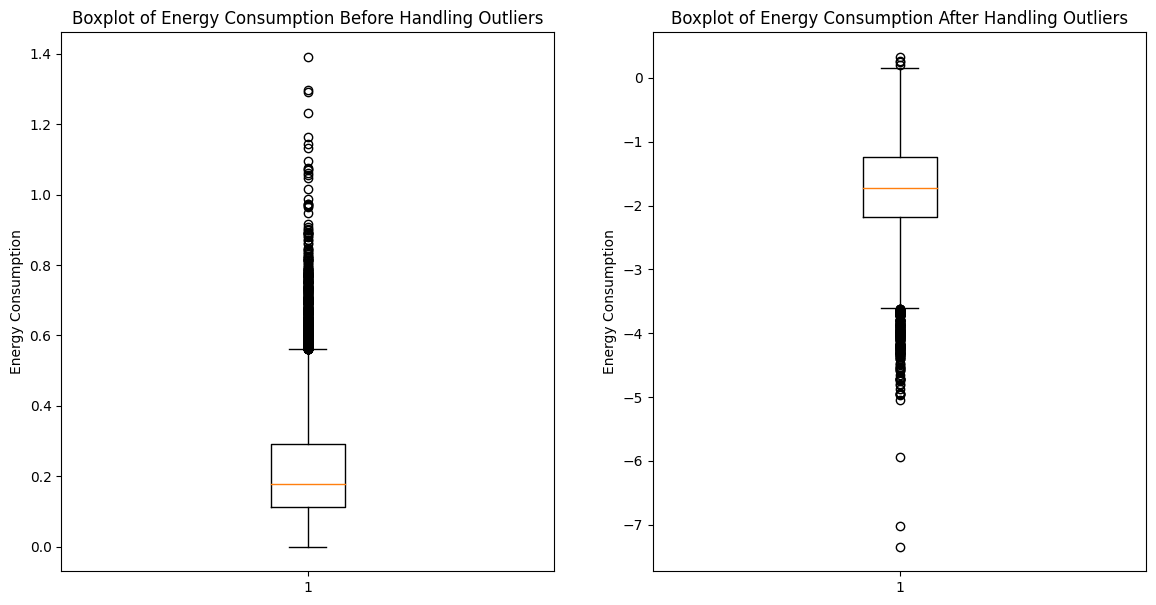

In [21]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
plt.boxplot(full_df_daily['KWH/hh (per half hour) '])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')

plt.subplot(1,2,2)
plt.boxplot(full_df_daily['log_KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.show()

In [22]:
def preprocess_data(df, time_step):
    data = df['KWH/hh (per half hour) '].values
    dates = df['Date'].values  # Using 'Date' column
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y, datestamps = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
        datestamps.append(dates[i + time_step])  # Store corresponding date
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    datestamps = np.array(datestamps)  # Convert list to numpy array
    return X, y, scaler, datestamps


In [23]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic, date_stamps_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard, date_stamps_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [24]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [25]:
# Train the LSTM model for dynamic users
model_dynamic = build_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)


Building LSTM model with input shape: (8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0147 - val_loss: 0.0141
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0121 - val_loss: 0.0127
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0122 - val_loss: 0.0128
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0118 - val_loss: 0.0123
Epoch 11/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 12/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/ste

In [26]:
# Train the LSTM model for standard users
model_standard = build_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_standard = model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)


Building LSTM model with input shape: (8, 1)
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0132 - val_loss: 0.0112
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124 - val_loss: 0.0077
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 12/20
78/78 ━━━━━━━━━━

In [27]:
# Predict consumption for dynamic users
pred_dynamic = model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard = model_standard.predict(X_test_std)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [28]:
# Check for NaNs in the predictions
if np.any(np.isnan(pred_standard)):
    print("NaN values found in standard TOU predictions.")
else:
    print("No NaN values in standard TOU predictions.")


No NaN values in standard TOU predictions.


In [29]:
# Inverse transform the predictions for dynamic users
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [30]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
peak_dynamic_time = y_test_dyn_inverse[np.argmax(pred_dynamic)]

# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
peak_standard_time = y_test_std_inverse[np.argmax(pred_standard)]


In [31]:
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
print(f"Corresponding Actual Dynamic TOU Consumption Value: {peak_dynamic_time}")

print(f"Peak Standard Consumption Value: {peak_standard_value}")
print(f"Corresponding Actual Standard TOU Consumption Value: {peak_standard_time}")


Peak Dynamic TOU Consumption Value: [0.48185965]
Corresponding Actual Dynamic TOU Consumption Value: [0.4731875]
Peak Standard Consumption Value: [0.9848246]
Corresponding Actual Standard TOU Consumption Value: [1.06102084]


In [32]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 0.08404332947987284
Standard TOU MAE: 0.0578422369863286


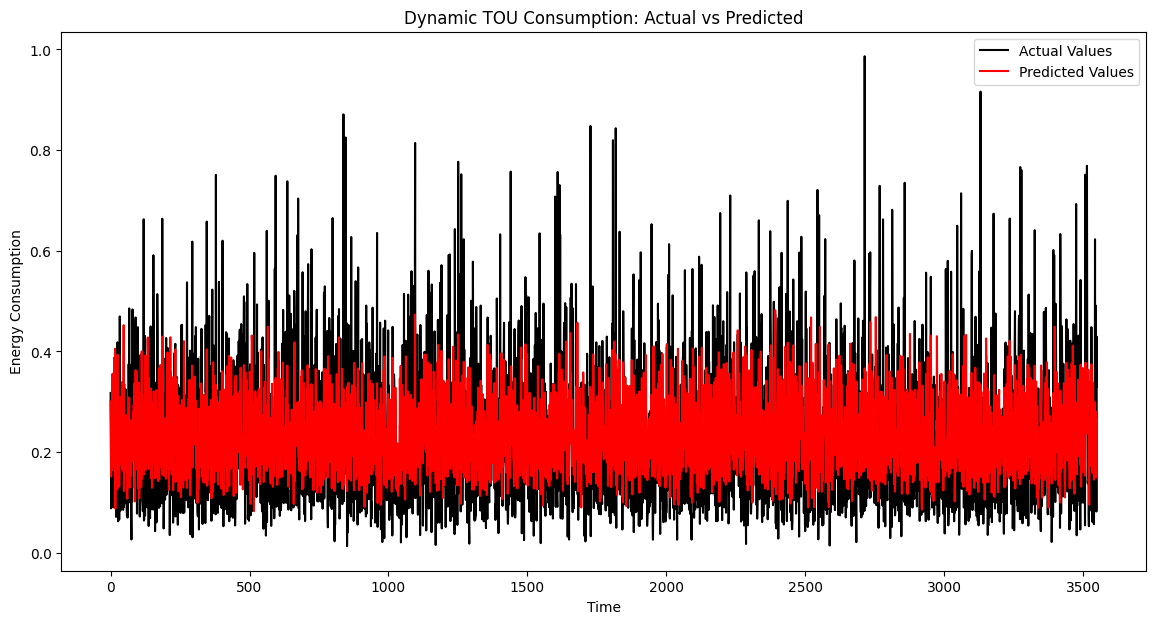

In [33]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()




In [34]:
model = KerasRegressor(build_fn=build_lstm_model, input_shape = (8,1), epochs=1, batch_size=32, verbose=0, dropout_rate=0.2, learning_rate=0.001, units=50)

In [35]:
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_dyn, y_train_dyn)

# Print the best parameters and score
print(f"Best parameters found: {grid_result.best_params_}")
print(f"Best score found: {grid_result.best_score_}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not

Building LSTM model with input shape: (8, 1)
Best parameters found: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.01, 'units': 50}
Best score found: -0.007305234758074095


In [36]:
# Build LSTM model
def best_grid_lstm_model(input_shape, units=100, dropout_rate=0.2, learning_rate=0.01):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [37]:
best_model_dynamic = best_grid_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_best_dynamic = best_model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0148 - val_loss: 0.0129
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096 - val_loss: 0.0081
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 11/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 1

In [38]:

best_model_standard = best_grid_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_best_standard = best_model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0198 - val_loss: 0.0083
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100 - val_loss: 0.0122
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_loss: 0.0050
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 12/20
78/78 ━━━━━━━━━━━

In [39]:
# Predict consumption for dynamic users
pred_dynamic1 = best_model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard1 = best_model_standard.predict(X_test_std)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [40]:
# Inverse transform the predictions for dynamic users
pred_dynamic1 = scaler_dynamic.inverse_transform(pred_dynamic1)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard1 = scaler_standard.inverse_transform(pred_standard1)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [41]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic1)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard1)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 0.0686135503005891
Standard TOU MAE: 0.05154124675569413


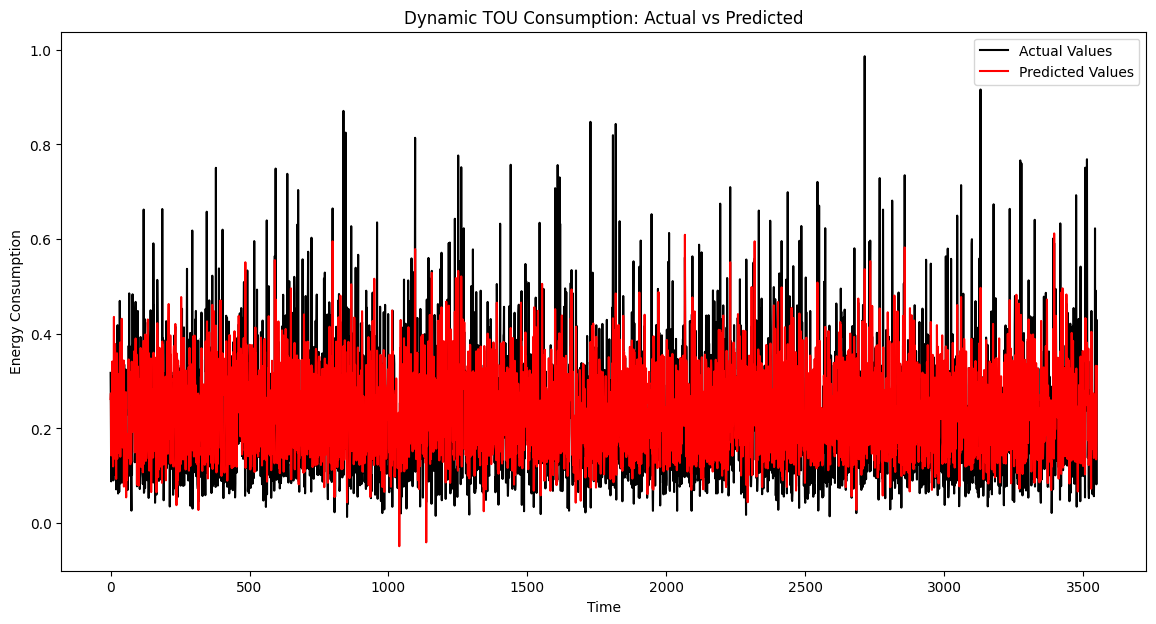

In [42]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic1, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [74]:
train_size_dynamic = int(len(df_dynamic) * 0.8)
train_dyn, test_dyn = df_dynamic.iloc[:train_size_dynamic], df_dynamic.iloc[train_size_dynamic:]


In [83]:
train_size_std = int(len(df_standard) * 0.8)
train_std, test_std = df_standard.iloc[:train_size_std], df_standard.iloc[train_size_std:]

<Figure size 1200x600 with 0 Axes>

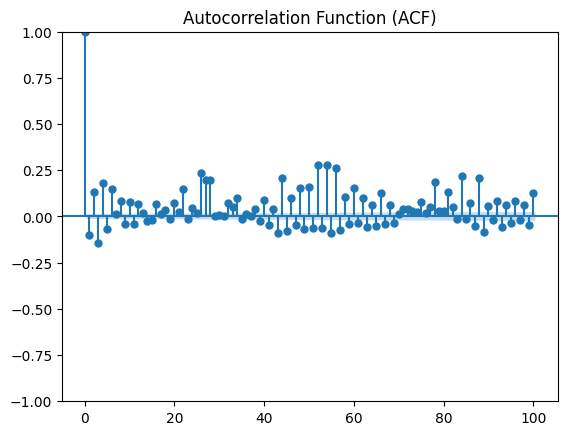

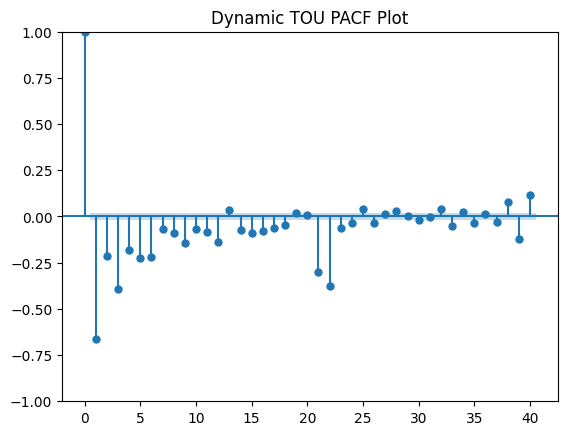

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

energy_values = full_df_daily['KWH/hh (per half hour) '].values
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(energy_values, lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.show()
plot_pacf(train_values, lags = 40)
plt.title('Dynamic TOU PACF Plot')
plt.show()


In [60]:
df_dynamic['KWH_diff'] = df_dynamic['KWH/hh (per half hour) '].diff()
df_dynamic.dropna(inplace=True)
df_dynamic.head(5)

<ipython-input-60-5b21768185d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dynamic['KWH_diff'] = df_dynamic['KWH/hh (per half hour) '].diff()
<ipython-input-60-5b21768185d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dynamic.dropna(inplace=True)


,Date,stdorToU,LCLid,KWH/hh (per half hour),KWH_diff
1,2011-11-24,ToU,MAC000146,0.178417,-0.008883
2,2011-11-25,ToU,MAC000146,0.140479,-0.037937
3,2011-11-26,ToU,MAC000146,0.125604,-0.014875
4,2011-11-27,ToU,MAC000146,0.119583,-0.006021
5,2011-11-28,ToU,MAC000146,0.127000,0.007417


In [61]:
train_size_dynamic = int(len(df_dynamic) * 0.8)
train_dyn, test_dyn = df_dynamic.iloc[:train_size_dynamic], df_dynamic.iloc[train_size_dynamic:]

<Figure size 1200x600 with 0 Axes>

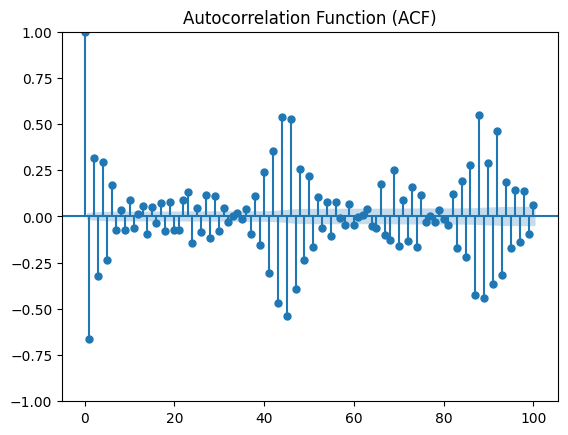

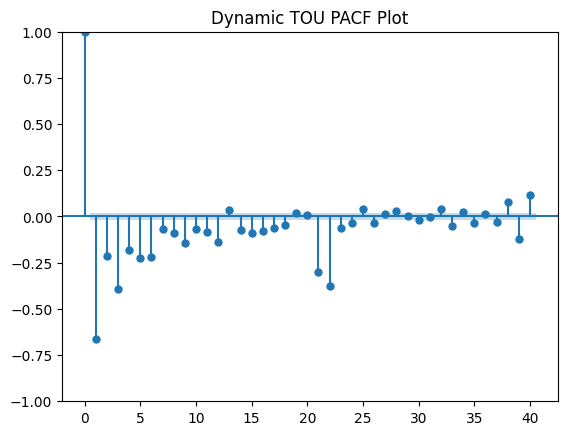

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train_values = train_dyn['KWH_diff'].values
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(train_values, lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.show()
plot_pacf(train_values, lags = 40)
plt.title('Dynamic TOU PACF Plot')
plt.show()